# Projet : Brain MRI Images for Brain Tumor Detection

## Importation des bibliotheques

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras.backend
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K
from keras.callbacks import History
import matplotlib.pyplot as plt
  
img_width, img_height = 224, 224
batch_size=32

2025-03-10 10:38:27.702428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Importation des données

In [2]:
class_names = ['no','yes']
directory='/Users/frikhmaissane/Documents/DeepLearning/archive'
# La fonction tf.keras.utils.image_dataset_from_directory permet de charger un ensemble d'images à partir d'un répertoire 
# et de les convertir en un dataset TensorFlow utilisable pour l'entraînement de modèles de deep learning.
# 'inferred' déduit les labels des noms des dossiers
# On choisit directement le format 'rgb' pour traiter les images
# On mélange les images pour pouvoir par la suite créer nos bases de test et d'entrainement 
# Choix du batch_size=32 : evite le sur-apprentissage. On slectionne les images par lots car trop compliqué de charger toutes les images à cause de la base de donnée

dataset = tf.keras.utils.image_dataset_from_directory(directory,labels='inferred',label_mode='int',class_names=class_names,color_mode='rgb', batch_size=32,
    image_size=(224,224), shuffle=True,seed=42)

# On definit la fonction splits qui permet de generer les bases d'entrainement et de test
def splits(dataset,Train_ratio,Test_ratio):
    data_size = len(dataset)
    train_dataset = dataset.take(int(data_size*Train_ratio))
    val_split_set = dataset.skip(int(data_size*Train_ratio)) 
    test_dataset = val_split_set.take((int(data_size*Test_ratio)))
    return train_dataset,test_dataset 

# Ces variables permettront de réajuster nos ratios si besoin pour faire differents tests
Train_ratio = 0.80 
Test_ratio = 0.20
train_dataset,test_dataset  = splits(dataset,Train_ratio,Test_ratio)
# Affiche le nombre de données dans chaque base
print("The length of the train_dataset is  : ",len(train_dataset)*batch_size)
print('The length of the test_dataset is  : ',len(test_dataset)*batch_size)
print(train_dataset)



Found 253 files belonging to 2 classes.
The length of the train_dataset is  :  192
The length of the test_dataset is  :  32
<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Prétraitement des données

In [3]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Vérification de la forme des images
for image, label in train_dataset.take(1):
    print("Avant normalisation -> Min pixel:", tf.reduce_min(image).numpy(), 
          "Max pixel:", tf.reduce_max(image).numpy(), 
          "Type:", image.dtype)

# Fonction de normalisation 
def normalize(image, label):
    # Vérifie si l'image est déjà entre [0,1]
    if tf.reduce_max(image) > 1.0:  
        image = tf.cast(image, tf.float32) / 255.0  # Normalisation
    return image, label

# Appliquer la normalisation uniquement si nécessaire
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Vérification après normalisation
for image, label in train_dataset.take(1):
    print("Après normalisation -> Min pixel:", tf.reduce_min(image).numpy(), 
          "Max pixel:", tf.reduce_max(image).numpy(), 
          "Type:", image.dtype)



Avant normalisation -> Min pixel: 0.0 Max pixel: 255.0 Type: <dtype: 'float32'>


2025-03-10 10:38:44.356353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Après normalisation -> Min pixel: 0.0 Max pixel: 1.0 Type: <dtype: 'float32'>


2025-03-10 10:38:44.686743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualisation des données

2025-03-10 10:38:46.956407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


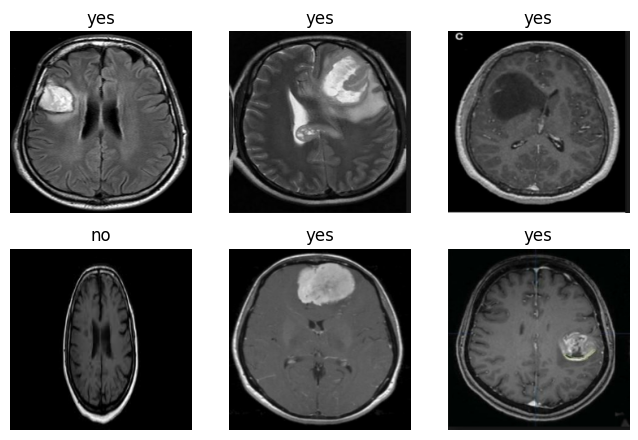

In [5]:
plt.figure(figsize=(8, 8))

for i, (image_batch, label_batch) in enumerate(train_dataset.take(6)):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[0])  # On prend la première image du batch
    plt.title(class_names[label_batch[0].numpy()])  # Extraction du label
    plt.axis("off")


## Création du modèle

Nous allons travailler sur cette base de données sans réaliser de changements

In [6]:
model = Sequential() 

model.add(Conv2D(16, (2, 2), input_shape=input_shape)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) #augmenter la taille et réduire la taille
  
model.add(Conv2D(16, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(32, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1)) 
model.add(Activation('sigmoid')) 

/Users/frikhmaissane/opt/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Entrainement du modèle partie 1

In [7]:
model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [8]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,  
    epochs=16)  


Epoch 1/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step - accuracy: 0.5949 - loss: 0.7225 - val_accuracy: 0.9375 - val_loss: 0.4927
Epoch 2/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - accuracy: 0.7394 - loss: 0.5668 - val_accuracy: 0.8750 - val_loss: 0.4389
Epoch 3/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 657ms/step - accuracy: 0.8059 - loss: 0.4668 - val_accuracy: 0.6875 - val_loss: 0.4811
Epoch 4/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - accuracy: 0.7907 - loss: 0.5000 - val_accuracy: 0.9375 - val_loss: 0.3205
Epoch 5/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.8188 - loss: 0.4319 - val_accuracy: 0.7812 - val_loss: 0.5056
Epoch 6/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 578ms/step - accuracy: 0.8006 - loss: 0.4129 - val_accuracy: 0.7812 - val_loss: 0.3756
Epoch 7/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step - accuracy: 0.8230 - loss: 0.3534 - val_accuracy: 0.8750 - val_loss: 0.3330
Epoch 8/16
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 605ms/step - accuracy: 0.8313 - loss: 0.3981 - val_accuracy: 0.9375 - val_loss:

## Evaluation du modèle

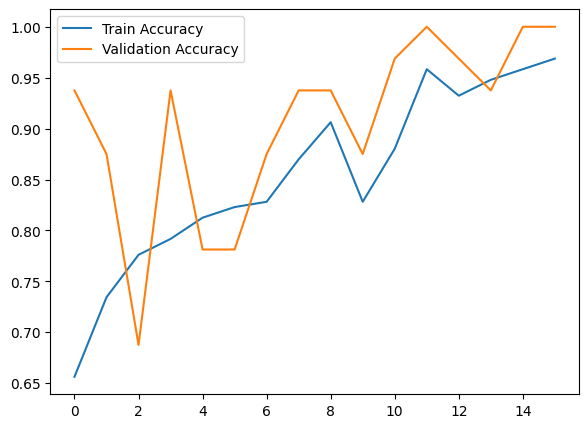

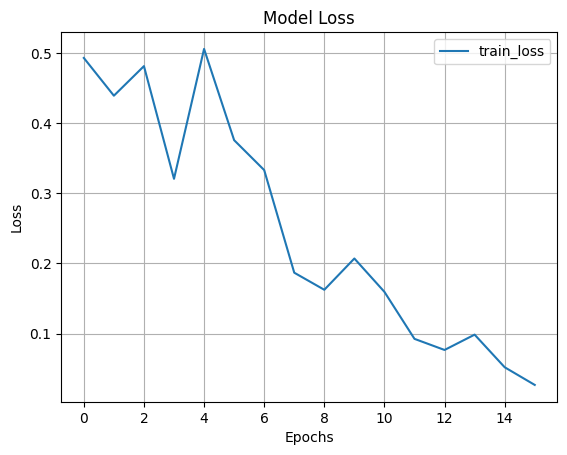

In [9]:
# Evaluation du modèle
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot model loss 

val_loss=history.history['val_loss']
plt.plot(val_loss)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])
plt.grid()


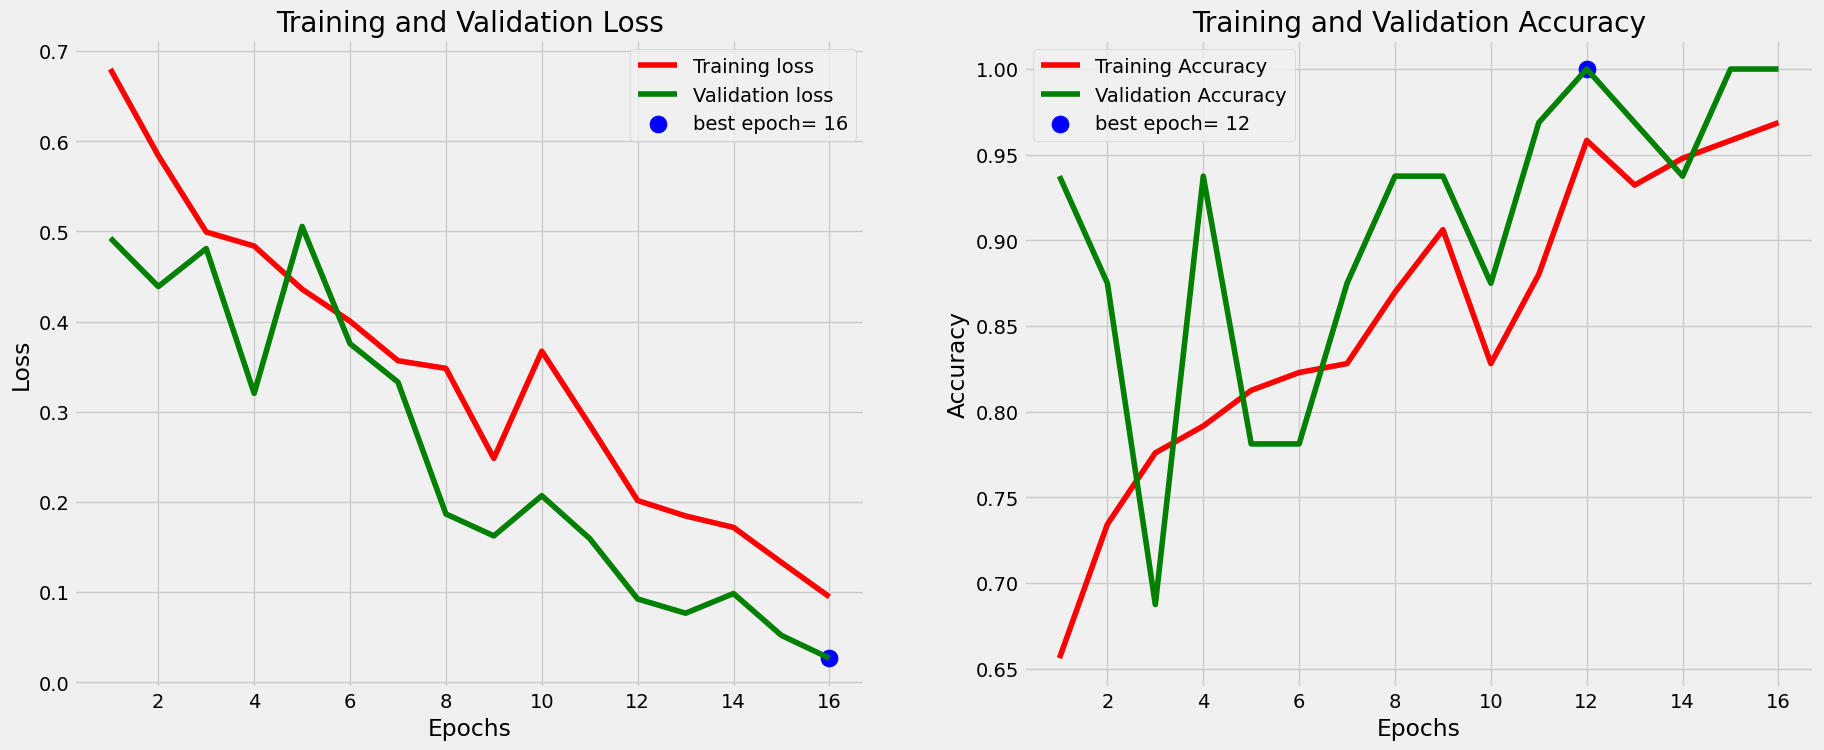

In [11]:
# Define needed variables
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_accuracy)
acc_highest = val_accuracy[index_acc]
Epochs = [i+1 for i in range(len(accuracy))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, accuracy, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_accuracy, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


## Entrainement du modèle partie 2 : Augementation des données

In [12]:
from tensorflow.keras import layers

# Augmentation des données uniquement pour le training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# On ne réaplique pas la normalisation des données car train_dataset est déja normalisé.
# Si on réaplique les pixels sont compris entre 0 et 0.004 donc l'image est noire.

# Appliquer la transformation aux datasets
train_dataset_new = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset_new = train_dataset.map(lambda x, y: (tf.clip_by_value(data_augmentation(x, training=True), 0.0, 1.0), y)) # Force les valeurs de pixels à rester dans [0,1]

for image, _ in train_dataset_new.take(1):  
    print("Min pixel:", tf.reduce_min(image).numpy(), "Max pixel:", tf.reduce_max(image).numpy()) # verifie la normalisation des images

for image, _ in train_dataset.take(1):  
    print("Min pixel:", tf.reduce_min(image).numpy(), "Max pixel:", tf.reduce_max(image).numpy()) # verifie la normalisation des images

train_dataset_final = train_dataset.concatenate(train_dataset_new) # Train datastet augmenté
for image, _ in train_dataset_final.take(1):  
    print("Min pixel:", tf.reduce_min(image).numpy(), "Max pixel:", tf.reduce_max(image).numpy()) # verifie la normalisation des images


Min pixel: 0.0 Max pixel: 1.0
Min pixel: 0.0 Max pixel: 1.0


2025-03-10 10:40:33.644730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-10 10:40:33.766577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Min pixel: 0.0 Max pixel: 1.0


2025-03-10 10:40:33.935698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-10 10:40:36.314235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


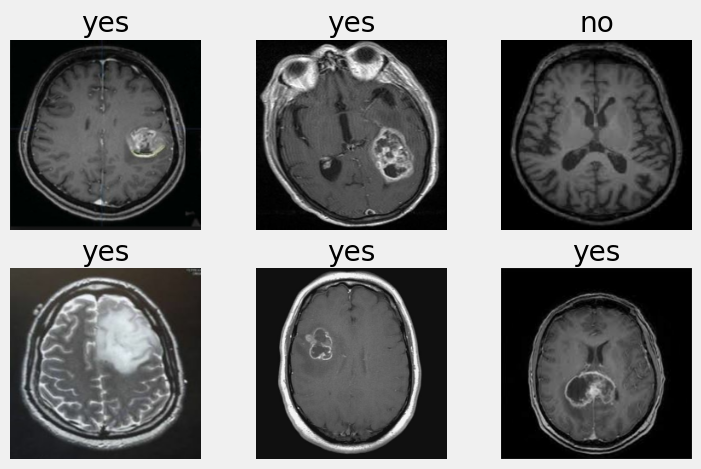

In [13]:
plt.figure(figsize=(8, 8))

for i, (image_batch, label_batch) in enumerate(train_dataset_final.take(6)):  
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[0])  # On prend la première image du batch
    plt.title(class_names[label_batch[0].numpy()])  # Extraction du label
    plt.axis("off")


In [14]:
history_new = model.fit(
    train_dataset_final,
    validation_data=test_dataset,
    epochs=9
)

Epoch 1/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 802ms/step - accuracy: 0.9151 - loss: 0.2624 - val_accuracy: 1.0000 - val_loss: 0.1579
Epoch 2/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 772ms/step - accuracy: 0.8823 - loss: 0.3268 - val_accuracy: 1.0000 - val_loss: 0.1867
Epoch 3/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 925ms/step - accuracy: 0.9053 - loss: 0.3041 - val_accuracy: 0.9375 - val_loss: 0.2137
Epoch 4/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 697ms/step - accuracy: 0.9238 - loss: 0.2474 - val_accuracy: 1.0000 - val_loss: 0.1292
Epoch 5/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 721ms/step - accuracy: 0.9117 - loss: 0.2381 - val_accuracy: 0.9375 - val_loss: 0.1527
Epoch 6/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 722ms/step - accuracy: 0.9262 - loss: 0.2187 - val_accuracy: 1.0000 - val_loss: 0.1064
Epoch 7/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step - accuracy: 0.9338 - loss: 0.2113 - val_accuracy: 1.0000 - val_loss: 0.0723
Epoch 8/9
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 908ms/step - accuracy: 0.9325 - loss: 0.2110 - val_accuracy: 1.0

## Évaluation du modèle final

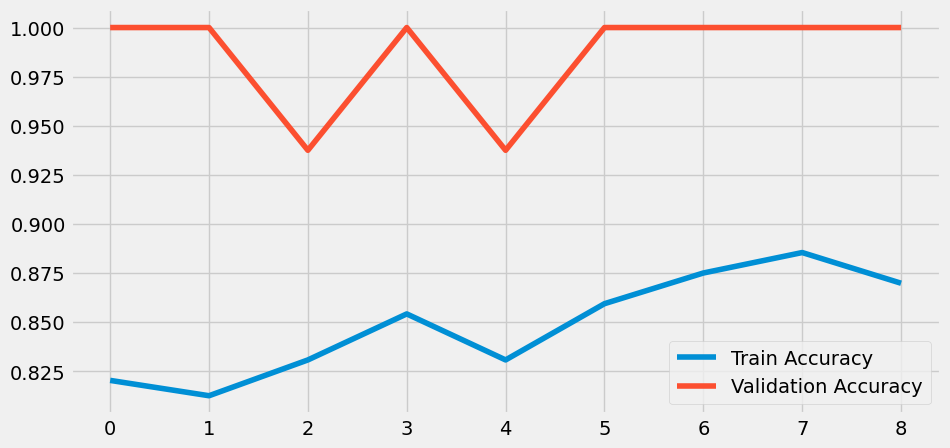

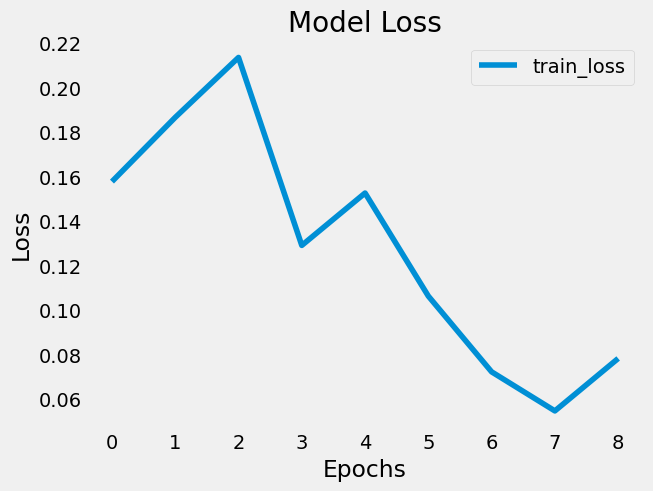

In [15]:
# Evaluation du modèle
plt.figure(figsize=(10,5))

plt.plot(history_new.history['accuracy'], label='Train Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot model loss 

val_loss=history_new.history['val_loss']
plt.plot(val_loss)
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])
plt.grid()

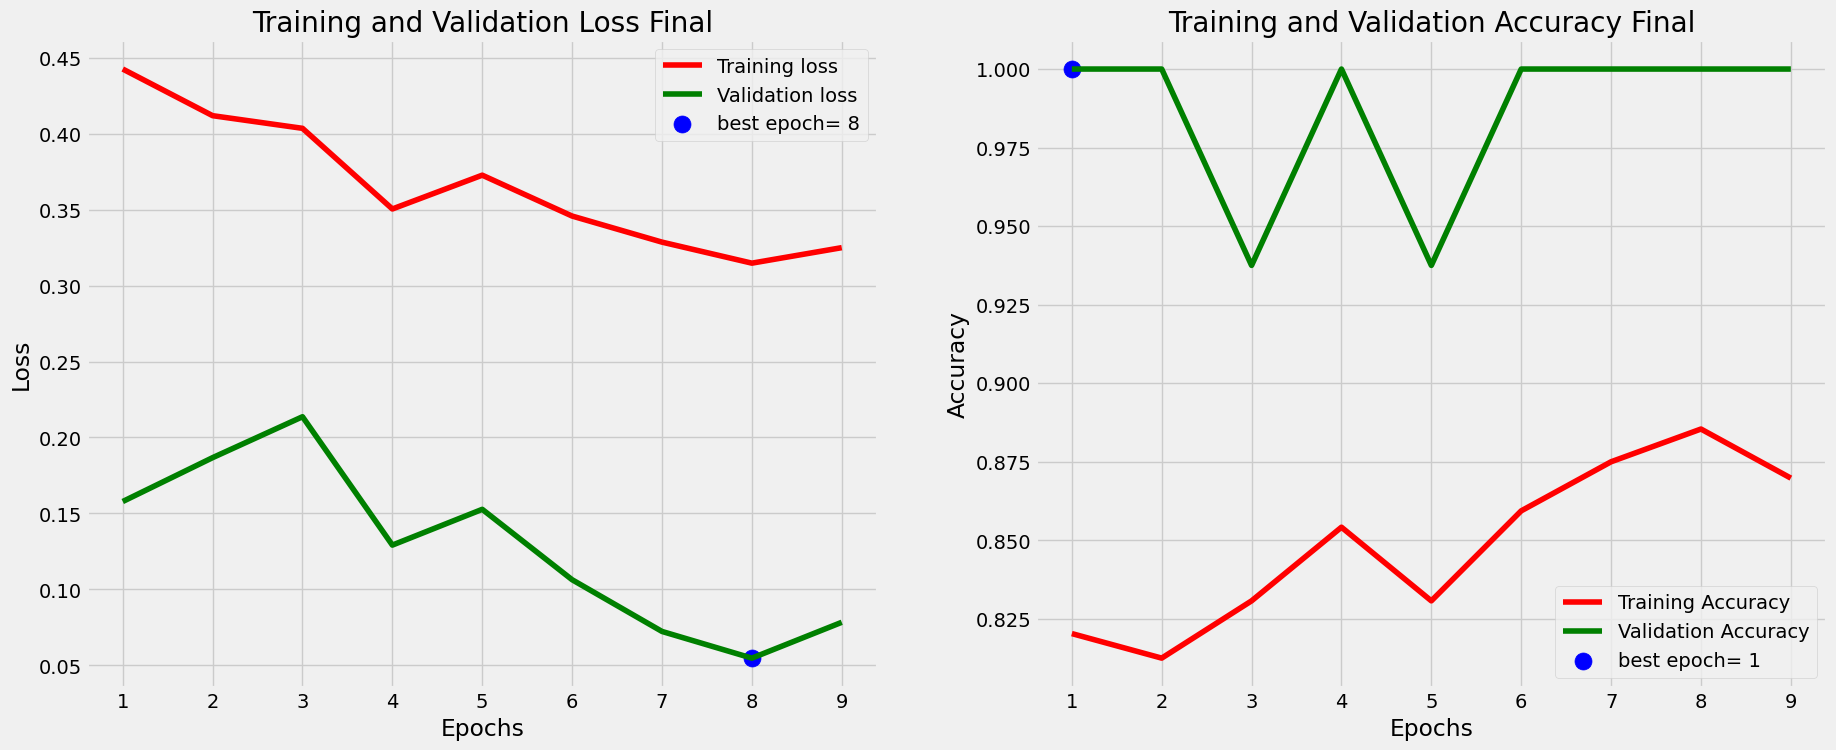

In [16]:
# Define needed variables
accuracy = history_new.history['accuracy']
loss = history_new.history['loss']
val_accuracy = history_new.history['val_accuracy']
val_loss = history_new.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_accuracy)
acc_highest = val_accuracy[index_acc]
Epochs = [i+1 for i in range(len(accuracy))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss Final')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, accuracy, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_accuracy, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy Final')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Enregistrement du modèle

In [17]:
model.save('tumor.keras') 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]


2025-03-10 10:43:03.870918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


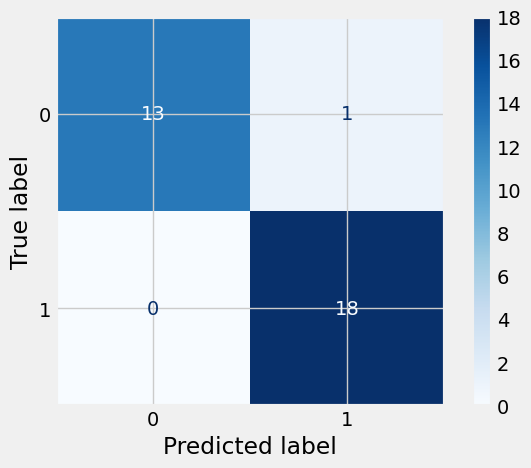

NameError: name 'Users' is not defined

In [21]:
from keras.models import load_model
from keras.preprocessing.image import load_img
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = load_model('tumor.keras')  

# Liste pour stocker les labels réels et prédits/Users/frikhmaissane/Documents/DeepLearning/Users/frikhmaissane/Documents/DeepLearning
y_true = []
y_pred = []

# Itérer sur le dataset pour obtenir les prédictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predictions = [1 if x>0.5 else 0 for x in predictions]
    y_true.extend(labels.numpy())
    
print(predictions)
print(y_true)
cm = confusion_matrix(y_true, predictions)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()/Users/frikhmaissane/Documents/DeepLearning